# Quantitative sensitivity analysis


## Generalized Sobol Indices

Here we show how to compute generalized Sobol indices on the **EOQ** model using the algorithm presented in Kucherenko et al. 2012. We import our model function from ``temfpy`` and use the Kucherenko indices function from ``econsa``. 

In [2]:
import matplotlib.pyplot as plt  # noqa: F401
import numpy as np

from temfpy.uncertainty_quantification import eoq_model

# TODO: Reactivate once Tim's PR is ready.
# from econsa.kucherenko import kucherenko_indices  # noqa: E265

The function ``kucherenko_indices`` expects the input function to be broadcastable over rows, that is, a row represents the input arguments for one evaluation. For sampling around the mean parameters we specify a diagonal covariance matrix, where the variances depend on the scaling of the mean. Since the variances of the parameters are unknown prior to our analysis we choose values such that the probability of sampling negative values is negligible. We do this since the **EOQ** model is not defined for negative parameters and the normal sampling does not naturally account for bounds.

In [2]:
def eoq_model_transposed(x):
    """EOQ Model but with variables stored in columns."""
    return eoq_model(x.T)

mean = np.array([1230, 0.0135, 2.15])
cov = np.diag([1, 0.000001, 0.01])

# indices = kucherenko_indices( # noqa: E265
#    func=eoq_model_transposed, # noqa: E265
#    sampling_mean=mean,  # noqa: E265
#    sampling_cov=cov,  # noqa: E265
#    n_draws=1_000_000,  # noqa: E265
#    sampling_scheme="sobol",  # noqa: E265
# )  # noqa: E265

Now we are ready to inspect the results.

In [3]:
# sobol_first = indices.loc[(slice(None), "first_order"), "value"].values  # noqa: E265
# sobol_total = indices.loc[(slice(None), "total"), "value"].values # noqa: E265

# x = np.arange(3)  # the label locations  # noqa: E265
# width = 0.35  # the width of the bars  # noqa: E265

# fig, ax = plt.subplots()  # noqa: E265
# rects1 = ax.bar(x - width / 2, sobol_first, width, label="First-order")  # noqa: E265
# rects2 = ax.bar(x + width / 2, sobol_total, width, label="Total")  # noqa: E265

# ax.set_ylim([0, 1])  # noqa: E265
# ax.legend()  # noqa: E265

# ax.set_xticks(x)  # noqa: E265
# ax.set_xticklabels(["$x_0$", "$x_1$", "$x_2$"])  # noqa: E265
# ax.legend();  # noqa: E265

In [4]:
# fig  # noqa: E265

## Shapley Effects

Here we show how to compute Shapley effects using the **EOQ** model as referenced above. We adjust the model in ``temfpy`` to accomodate an n-dimensional array for use in the ``econsa`` Shapley effects context. 

In [8]:
# import necessary packages and functions
import numpy as np
import pandas as pd
import chaospy as cp
import matplotlib.pyplot as plt
import seaborn as sns

from econsa.shapley import get_shapley
from econsa.shapley import _r_condmvn

Load all neccesary inputs for the model, you will need:
- a vector of mean estimates
- a covariance matrix
- the model you are conducting SA on
- the functions ``x_all`` and ``x_cond`` for conditional sampling. These functions depend on the distribution from which you are sampling from - for the purposes of this illustration, we will sample from a multvariate normal distribution, but the functions can be tailored to the user's specific needs.

In [9]:
# mean and covaraince matrix inputs
n_inputs = 3
mean = np.array([5.345, 0.0135, 2.15])
cov = np.diag([1, 0.000001, 0.01])

In [10]:
# model for which senstivity analysis is being performed
def eoq_model_ndarray(x, r=0.1):
    """EOQ Model that accepts ndarray."""
    m = x[:,0]
    c = x[:,1]
    s = x[:,2]    
    return np.sqrt((24 * m * s) / (r * c))    

In [11]:
# functions for conditional sampling
def x_all(n):
    distribution = cp.MvNormal(mean, cov)
    return distribution.sample(n)

def x_cond(n, subset_j, subsetj_conditional, xjc):
    if subsetj_conditional is None:
        cov_int = np.array(cov)
        cov_int = cov_int.take(subset_j, axis = 1)
        cov_int = cov_int[subset_j]
        distribution = cp.MvNormal(mean[subset_j], cov_int)
        return distribution.sample(n)
    else:
        return _r_condmvn(n, mean = mean, cov = cov, dependent_ind = subset_j, given_ind = subsetj_conditional, x_given = xjc)

In [13]:
# estimate Shapley effects using the exact method
method = 'exact'
np.random.seed(1234)
n_perms = None
n_output = 10**4
n_outer = 10**3
n_inner = 10**2

exact_shapley = get_shapley(method, eoq_model_ndarray, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)

In [14]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
X1,0.814539,0.003178,0.808311,0.820768
X2,0.130068,0.003394,0.123416,0.136721
X3,0.055392,0.004386,0.046797,0.063988


In [15]:
# estimate Shapley effects using the random method
method = 'random'
np.random.seed(1234)
n_perms = 25000
n_output = 10**4
n_outer = 1
n_inner = 3


random_shapley = get_shapley(method, eoq_model_ndarray, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)

In [16]:
random_shapley

,Shapley effects,std. errors,CI_min,CI_max
X1,0.814734,0.004659,0.805602,0.823866
X2,0.130517,0.004570,0.121561,0.139473
X3,0.054749,0.004739,0.045461,0.064038


Now we plot the ranking of the Shapley values below.

In [17]:
# comparison of exact and random method ranking
data = {'inputs':['X1', 'X2', 'X3'], 'exact_method':[0.814539, 0.130068, 0.055392],
        'random_method': [0.814734, 0.130517, 0.054749]}

# covert dict to dataframe for plot
df = pd.DataFrame(data)

# Set up a grid to plot survival probability against several variables
def ranking(data):
    g = sns.PairGrid(data.sort_values("exact_method", ascending=False),
                     x_vars=data.columns[-2:], y_vars=["inputs"],
                     height=4, aspect=.9)

    # Draw a dot plot using the stripplot function
    g.map(sns.stripplot, size=10, orient="h", linewidth=1, edgecolor="w")

    # Use the same x axis limits on all columns and add better labels
    g.set(xlim=(0, 0.9), xlabel="Shapley effect", ylabel="")

    # Use semantically meaningful titles for the columns
    titles = ["exact method", "random method"]

    for ax, title in zip(g.axes.flat, titles):

        # Set a different title for each axes
        ax.set(title=title)

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

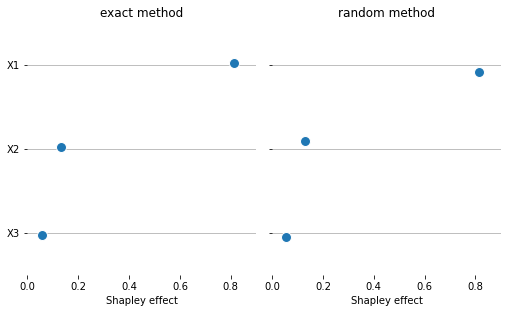

In [18]:
# plot for exact and random permutations methods
ranking(data = df)

As noticed above, both mwthods produce te same ranking. Sometimes, it is neccesary to compare the parameter estimates with their parameter values. A typical thing to want to check for is whether the parameter estimates are significant, and what the contribution of significant / insignificant estimates is to the output variance as reflected by their Shapley ranking.

We can plot the parameter estimates together with their Shapley ranking as shown below:

In [22]:
# plot for exact permutations method
def ranking_params_shapley(ordered_df):
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
    plt.hlines(y=my_range, xmin=ordered_df['params'], xmax=ordered_df['shapley_effect'], color='grey', alpha=0.4)
    plt.scatter(ordered_df['params'], my_range, color='skyblue', alpha=1, label='params')
    plt.scatter(ordered_df['shapley_effect'], my_range, color='green', alpha=0.4 , label='shapley_effect')
    plt.legend()
     
    # Add title and axis names
    plt.yticks(my_range, ordered_df['inputs'])
    plt.title("Comparison of params and Shapley effects", loc='left')
    plt.xlabel('Value of the variables')
    plt.ylabel('Group')

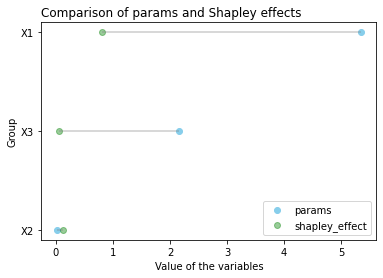

In [23]:
# plot exact method comparison
df = {'inputs':['X1', 'X2', 'X3'], 'params':[5.345, 0.0135, 2.15],
        'shapley_effect': [0.814539, 0.130068, 0.055392]}

df_exact = pd.DataFrame(df)
ordered_df = df_exact.sort_values(by='params')
my_range = range(1,len(df_exact.index)+1)

ranking_params_shapley(ordered_df)

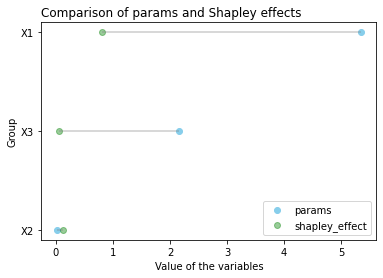

In [24]:
# plot random method comparison
df = {'inputs':['X1', 'X2', 'X3'], 'params':[5.345, 0.0135, 2.15],
        'shapley_effect': [0.814734, 0.130517, 0.054749]}

df_exact = pd.DataFrame(df)
ordered_df = df_exact.sort_values(by='params')
my_range = range(1,len(df_exact.index)+1)

ranking_params_shapley(ordered_df)

#### When do I use which method?
The `exact` method is good for use when the number of parameters is low, depending on the computational time it takes to estimate the model in question. If it is computationally inexpensive to estimate the model for which sensitivity analysis is required, then the `exact` method is always preferable, otherwise the `random` is recommended. A good way to proceed if one suspects that the computational time required to estimate the model is high, having a lot of parameters to conduct SA on is always to commence the exercise with a small number of parameters, e.g. 3, then get a benchmark of the Shapley effects using the `exact` method. Having done that, repeat the exercise using the `random` method on the same vector of parameters, calibrating the `n_perms` argument to the make sure that the results produced by the `random` method are the same as the `exact` one. Once this is complete, scale up the exercise using the `random` method, increasing the number of parameters to the desired parameter vector.